## Inventory management problem

In this example we study **Inventory management problem**.

The firm faces stochastic demand $D$. It sells each demanded unit at a price $p$. The firm can sell at most $X$ units, the size of its inventory.

Every period it has to decide whether to place an order. If it decides to do so, it has to choose the amount of goods ordered $F$. It pays $c$ per each unit ordered and a fixed cost of ordering equal to $K$. 

There is a maximum inventory size, $\bar{X}$.

The firm maximizes present discounted value of profits. 

It discounts future at $\beta\in(0,1)$.

Bellman equation is 

$$v(X,D) = \max_F  p \cdot \min \left\{D,X\right\} - c \cdot F - K \cdot \mathbb{I}_{F>0}  +  \beta E_{X,D} v(\min\left\{\max \left\{X-D,0\right\} + F,\bar{X}\right\},D^\prime)$$ 




In [1]:
using Pkg
Pkg.activate("..") ## because we have environment files in the parent directory
Pkg.instantiate() ## to download all missing packages


  Activating project at `c:\Users\piotr\Dropbox\WNE\QuantEcon_all\QEcon2023\Code`

In [2]:
# load some packages we will need today
using Distributions, QuantEcon, IterTools, Plots

In [3]:

function create_inventory_model(; 
    p = 4, # price per unit
    d_par = 0.3, # demand distribution parameter
    ϕ = Geometric(d_par),
    X_max = 30, # maximum inventory
    K = 2, # cost of placing an order
    c = 1, # cost of unit ordered
    β = 0.99, # discount factor
    X_vec = 0:X_max # vector of possible inventory levels

    )
   
    return (; p, ϕ, X_max, K, c, β,X_vec)
    end

create_inventory_model (generic function with 1 method)

In [5]:
function T_operator(v,model)

    (;p, ϕ, X_max, K, c, β, X_vec) = model

    v_new = similar(v)
    σ_ind_new = zeros(Int64,length(X_vec),length(X_vec))
    σ_new = zeros(length(X_vec),length(X_vec))

    for (d_ind, d) in enumerate(X_vec)
        for (x_ind, x) in enumerate(X_vec)
    
            RHS_vec = zeros(length(X_vec))
            for (x_next_ind, x_next) in enumerate(X_vec)
                
                sold = min(d,x)
                revenue = p * sold - K * (x_next > (x - sold)) - c * (x_next - (x - sold))
                
                if x_next >= x - sold
                    RHS_vec[x_next_ind] = revenue + β * sum( v[x_next_ind,d_next_ind] * pdf(ϕ,d_next_ind-1) for d_next_ind in 1:X_max+1 )
                else
                    RHS_vec[x_next_ind] = -Inf
                end
    
            end
    
            v_new[x_ind,d_ind], σ_ind_new[x_ind,d_ind] = findmax(RHS_vec)
            σ_new[x_ind,d_ind] = X_vec[σ_ind_new[x_ind,d_ind]]
        end
    end
    return v_new, σ_new
end


T_operator (generic function with 1 method)

In [7]:

function vfi(model; tol = 1e-6, maxiter = 1000)

    (;p, ϕ, X_max, K, c, β, X_vec) = model
    
    tol = 1e-6; maxiter = 1000
    error = tol + 1.0; iter = 1 #  initialize
    v = zeros(X_max+1,X_max+1); 
    while error > tol && iter < maxiter
        v_new, σ = T_operator(v,model)
        error = maximum(abs.(v_new .- v))
        v = v_new
        iter += 1
    end
    # one more iteration to get the policy function
    v, σ = T_operator(v,model)
    return v, σ, iter, error
    
end

vfi (generic function with 1 method)

In [8]:
model = create_inventory_model()


v, σ, iter, error = vfi(model)

([647.214921018575 647.214921018575 … 647.214921018575 647.214921018575; 648.214921018575 651.214921018575 … 651.214921018575 651.214921018575; … ; 678.1711610863534 681.1229011205434 … 763.214921018575 763.214921018575; 679.214921018575 682.1711610863534 … 764.214921018575 767.214921018575], [30.0 30.0 … 30.0 30.0; 30.0 30.0 … 30.0 30.0; … ; 29.0 28.0 … 30.0 30.0; 30.0 29.0 … 30.0 30.0], 1000, 0.0002871720174653092)

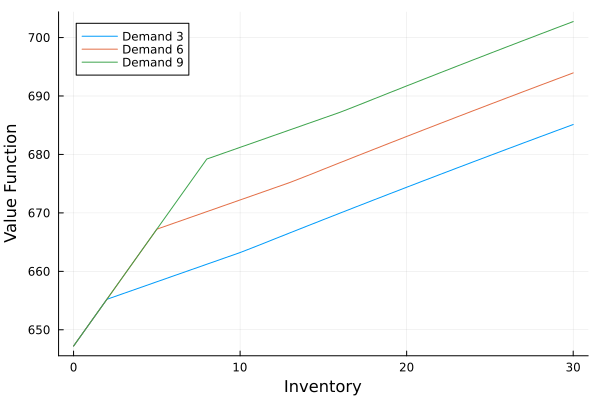

In [9]:

(;p, ϕ, X_max, K, c, β, X_vec) = model
plot(X_vec, v[:, 3], label="Demand 3")
plot!(X_vec, v[:, 6], label="Demand 6")
plot!(X_vec, v[:, 9], label="Demand 9", xlabel="Inventory", ylabel="Value Function")


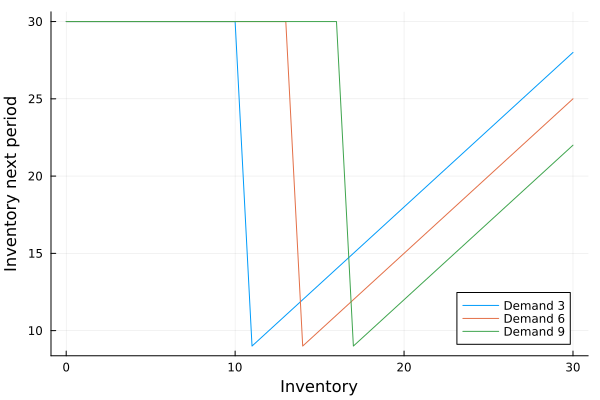

In [10]:
plot(X_vec, σ[:, 3], label="Demand 3")
plot!(X_vec, σ[:, 6], label="Demand 6")
plot!(X_vec, σ[:, 9], label="Demand 9", xlabel="Inventory", ylabel="Inventory next period")

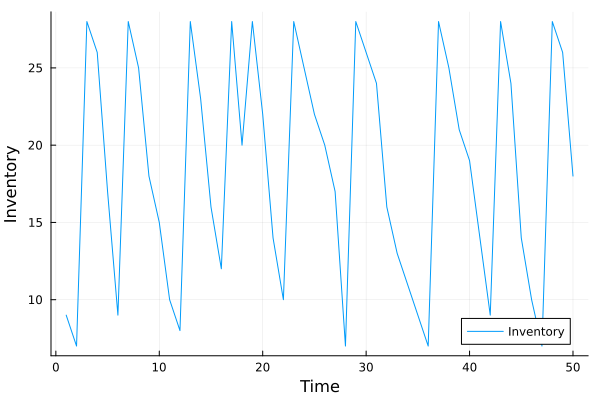

In [11]:

    P = Matrix{Float64}(undef, X_max+1, X_max+1)
    for (i, j) in product(1:X_max+1, 1:X_max+1)
    P[i, j] = sum((σ[i, d+1] == j+1) * pdf(ϕ, d) for d in 0:X_max)
    end

    # normalize (we truncated the distribution of shocks at X_max)
    for i in 1:X_max+1
    P[i,:] = P[i,:] / sum(P[i,:])
    end



    mc = MarkovChain(P, X_vec)
    X_ts = simulate(mc, 50, init = 10);

    plot(X_ts, label="Inventory", xlabel="Time", ylabel="Inventory")

    


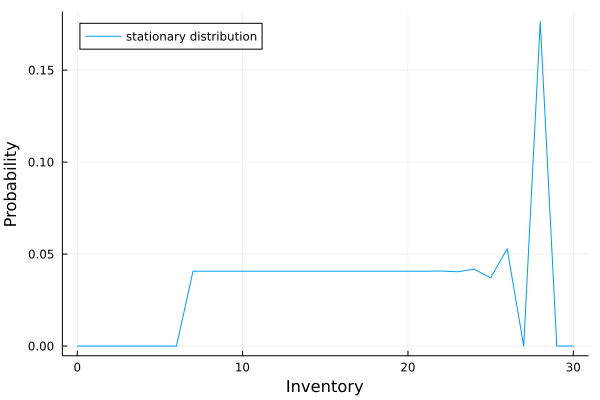

In [12]:
Ψ = stationary_distributions(mc)[1]
plot(X_vec, Ψ, label="stationary distribution", xlabel="Inventory", ylabel="Probability")